# Аналитика рынка труда криптосферы

Главный вопрос:
1. Какую долю рынка можно занять?

Сопутствующие вопросы:
1. Общее кол-во вакансий в сфере?
2. Топ компаний с открытми вакансиями?
3. Топ компаний, закрывающие вакансии в сфере?
4. Ср зарплата специалиста в сфере?
5. В каких странах вакансии?
6. Требования к сотрудникам?

In [ ]:
# кол-во вакансий по теме, class - "relative z-10 flex flex-col items-center justify-center w-full px-10 py-10"
# таблица с вакансиями, table class - "w-full job-preview-inline-table @[500px]:![--vertical-spacing:1.5rem] @[500px]:![--image-size:60px] @[500px]:![--container-padding:.8rem]"

In [14]:
import re


from selenium import webdriver
from selenium.webdriver.common.keys import Keys
from selenium.webdriver.common.by import By
from selenium.webdriver.support.wait import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC

import pandas as pd

from math import ceil

from tqdm import tqdm

In [39]:
class CryptoJobListSearchParser():
    cnt_showed_vacancies = 25 # fixed cnt of showed vacancies
    job_tags_for_parse = [
        "a.job-title-text",
        "a.job-company-name-text",
        "td.inline-block.-mt-1 span.job-salary-text",
        "td.job-tags",
        "td.job-time-since-creation",
        "td.inline-block.-mt-1 span.job-location-text"
    ]

    def __init__(self):
        self.driver = None

    def main_parse_crypto_job_list(self):
        self.driver = webdriver.Firefox()
        self.driver.get("https://cryptojobslist.com")
        self.driver.implicitly_wait(5) # seconds
        
        # получаю текущее кол-во открытых вакансий
        cnt_job_showed = self.parse_viewed_jobs(self)
        
        needed_clicks = ceil(cnt_job_showed / CryptoJobListSearchParser.cnt_showed_vacancies) - 1
        for i in range(needed_clicks):
            # Ждем, пока кнопка станет кликабельной и кликаем
            button = WebDriverWait(self.driver, 50).until(EC.element_to_be_clickable((By.XPATH, "//button[contains(text(), 'Load more')]"))) 
            
            try:
                button.click()
            except:
                # Прокрутим страницу до элемента
                self.driver.execute_script("arguments[0].scrollIntoView(true);", button)
                
                # Теперь попытаемся кликнуть
                self.driver.execute_script("arguments[0].click();", button)
                #button.click()
            
        df_parsed_job_info = pd.DataFrame.from_records(self.parse_job_table(self))
        
        df_parsed_job_info.rename(
            columns={
                "a.job-title-text": "Job Title",
                "a.job-company-name-text": "Job Company",
                "td.inline-block.-mt-1 span.job-salary-text": "Job Salary",
                "td.job-tags": "Job Tags",
                "td.job-time-since-creation": "Job Time Since",
                "td.inline-block.-mt-1 span.job-location-text": "Job Location"
            },
            inplace=True
        )
        
        df_parsed_job_info.to_csv("CryptoJobListSearchDataset.csv", index=False)
        
        self.driver.close()
    
    @staticmethod    
    def parse_viewed_jobs(self):
        # Находим родительский блок по его классу
        parent_block = self.driver.find_element(By.CSS_SELECTOR, 'div.relative.z-10.flex.flex-col')
        
        # Находим внутренний div, который содержит текст (первый div внутри)
        text_cnt_crypto_jobs_div = parent_block.find_element(By.XPATH, './div[1]')
        
        # Извлекаем текст из найденного элемента
        text_cnt_crypto_jobs = text_cnt_crypto_jobs_div.text
        
        numbers = list(map(int, re.findall(r'\d+', text_cnt_crypto_jobs)))
        
        return max(numbers)
    
    @staticmethod
    def parse_job_table(self):
        list_job_info = []
        
        table = self.driver.find_elements(By.TAG_NAME, 'tr')[1:] # беру таблицу с вакансиями от первого блока и до последнего
        for job_block in tqdm(table):
            job_dict_info = {}
            for tag in CryptoJobListSearchParser.job_tags_for_parse:
                parsed_block = self.parse_job_block(job_block, tag)
                job_dict_info[tag] = parsed_block
            list_job_info.append(job_dict_info)
        
        return list_job_info
    
    @staticmethod
    def parse_job_block(web_element, job_block_name):
        try:
            parsed_block_text = web_element.find_element(By.CSS_SELECTOR, job_block_name).text
        except:
            parsed_block_text = None
        return parsed_block_text
        

In [40]:
parser = CryptoJobListSearchParser()

dataset_crypto_job_list = parser.main_parse_crypto_job_list()

100%|██████████| 375/375 [45:10<00:00,  7.23s/it]


# Разбор Датасета на дату 2024-10-08

In [42]:
df_crypto_jobs = pd.read_csv('CryptoJobListSearchDataset.csv')

In [45]:
df_crypto_jobs.describe()

,Job Title,Job Company,Job Salary,Job Tags,Job Time Since,Job Location
count,375,375,53,375,375,159
unique,369,52,38,163,11,67
top,Binance Accelerator Program - Product Experien...,Token Metrics,$3-5/hour,RemoteWeb3DeveloperEngineering,4d,"Taiwan, Taipei"
freq,2,151,7,26,62,32


### 1. Имеем 375 вакансий для разбора
### 2. Среди которых 52 уникальные компании, 67 локаций 

In [63]:
from collections import Counter

def add_space_into_string(text):
    # Добавляем пробел перед каждой заглавной буквой, кроме первой
    return re.sub(r'([A-Z])', r' \1', text).strip()

In [46]:
df_crypto_jobs

,Job Title,Job Company,Job Salary,Job Tags,Job Time Since,Job Location
0,Senior Front End Engineer,BaseDEX US [Stealth],$120k-180k/year,DeveloperExchangeTypeScriptReact,3w,NYC
1,SMM Specialist (Web3),WeWay,$2k-3k/month,RemoteWeb3MarketingNon Tech,Today,Remote
2,Business Developer (Web3),WeWay,$3k-4k/month,Business DevelopmentWeb3DeFiRemote,Today,Remote
3,Web3 Solidity Bootcamp - Job Guaranteed,"Metana, Inc.",$50k-200k/year,DeveloperWeb3SolidityEthereum,4w,NaN
4,Senior Frontend Engineer,prePO,$130k-300k/year,EngineeringRemoteUI/UXTypeScript,4w,NaN
...,...,...,...,...,...,...
370,Crypto Chief of Staff (Panama-remote),Token Metrics,NaN,RemoteWeb3ContentOperations,Today,NaN
371,Mobile Application Developer - React Native,Token Metrics,NaN,Web3DeveloperNon TechTypeScript,Today,[object Object]
372,Crypto Investment Analyst Intern (Pakistan-Rem...,Token Metrics,NaN,RemoteWeb3ResearchAnalyst,Today,NaN
373,Crypto Business Development Intern (Ottawa-Rem...,Token Metrics,NaN,RemoteWeb3MarketingSales,Today,NaN


In [57]:
# Преобразуем все данные столбца в одну строку
all_text = ' '.join(df_crypto_jobs['Job Title'].astype(str))

# Удалим лишние символы и разбиваем строку на слова
words = re.findall(r'\b\w+\b', all_text.lower())

# Подсчитаем количество повторений каждого слова
word_counts = Counter(words)

# Найдем наиболее частые слова
most_common_words = word_counts.most_common(10)  # 10 самых частых слов
print(most_common_words)

[('remote', 143), ('crypto', 111), ('engineer', 74), ('manager', 59), ('senior', 56), ('of', 41), ('analyst', 38), ('head', 36), ('developer', 30), ('binance', 30)]


In [59]:
df_crypto_jobs["Job Company"].value_counts()

Job Company
Token Metrics                                      151
Binance                                            126
Polygon Labs                                        16
Chainalysis                                          9
Flashbots                                            5
Shakepay                                             5
InfiniFi Labs                                        4
Dx Sale                                              3
Treehouse Labs                                       3
P2P.org                                              3
Pionex                                               3
Ledger                                               2
Metaschool                                           2
Linera                                               2
WeWay                                                2
Interop Labs                                         2
DappRadar                                            2
Office of the New York State Attorney General        

In [60]:
df_crypto_jobs["Job Salary"].value_counts()

Job Salary
$3-5/hour            7
$3k/month            3
$3-5/year            2
$1-2/hour            2
$5-10/hour           2
$90k-120k/year       2
$5k/month            2
$30k-50k/year        2
$1k/month            2
$70k-100k/year       1
$94k-184k/year       1
$6-10/hour           1
$2-4/hour            1
$60k/year            1
$40k-60k/year        1
$12-15/hour          1
$2k-4k/month         1
$1-2/year            1
$3k-5k/month         1
$3-6/hour            1
$50k-65k/year        1
$120k-180k/year      1
$3k-6k/month         1
$4-5/hour            1
$2k-3k/month         1
$95k/year            1
EUR 18k-24k/year     1
EUR 48k-60k/year     1
$80k-92k/year        1
$60k-70k/year        1
$1.5k-4.5k/month     1
$66.3k-69.7k/year    1
$70k-85k/year        1
$60k-180k/year       1
$130k-300k/year      1
$50k-200k/year       1
$3k-4k/month         1
$5-8/hour            1
Name: count, dtype: int64

In [61]:
df_crypto_jobs[["Job Title", "Job Salary"]].value_counts()

Job Title                                                      Job Salary       
AML Analyst                                                    $3k-5k/month         1
KYB Analyst - Offshore &amp; VIP                               $3-5/hour            1
MEV Engineering Intern                                         $5k/month            1
Market Making Manager                                          $30k-50k/year        1
Marketing Consultant                                           $70k-85k/year        1
Operations Business Analyst - Dubai                            $1-2/hour            1
Process Excellence Manager                                     $3-5/hour            1
Product Designer                                               EUR 48k-60k/year     1
Recruiter / Talent Acquisition Specialist (6 months contract)  $2k-4k/month         1
SAR Analyst                                                    $3-5/year            1
SMM Specialist (Web3)                                      

In [65]:
df_crypto_jobs["Job Tags"] = df_crypto_jobs["Job Tags"].apply(add_space_into_string)

In [66]:
df_crypto_jobs

,Job Title,Job Company,Job Salary,Job Tags,Job Time Since,Job Location
0,Senior Front End Engineer,BaseDEX US [Stealth],$120k-180k/year,Developer Exchange Type Script React,3w,NYC
1,SMM Specialist (Web3),WeWay,$2k-3k/month,Remote Web3 Marketing Non Tech,Today,Remote
2,Business Developer (Web3),WeWay,$3k-4k/month,Business Development Web3 De Fi Remote,Today,Remote
3,Web3 Solidity Bootcamp - Job Guaranteed,"Metana, Inc.",$50k-200k/year,Developer Web3 Solidity Ethereum,4w,NaN
4,Senior Frontend Engineer,prePO,$130k-300k/year,Engineering Remote U I/ U X Type Script,4w,NaN
...,...,...,...,...,...,...
370,Crypto Chief of Staff (Panama-remote),Token Metrics,NaN,Remote Web3 Content Operations,Today,NaN
371,Mobile Application Developer - React Native,Token Metrics,NaN,Web3 Developer Non Tech Type Script,Today,[object Object]
372,Crypto Investment Analyst Intern (Pakistan-Rem...,Token Metrics,NaN,Remote Web3 Research Analyst,Today,NaN
373,Crypto Business Development Intern (Ottawa-Rem...,Token Metrics,NaN,Remote Web3 Marketing Sales,Today,NaN


In [67]:
# Преобразуем все данные столбца в одну строку
all_tags = ' '.join(df_crypto_jobs['Job Tags'].astype(str))

# Удалим лишние символы и разбиваем строку на слова
tags = re.findall(r'\b\w+\b', all_tags.lower())

# Подсчитаем количество повторений каждого слова
tag_counts = Counter(tags)

# Найдем наиболее частые слова
most_common_tags = tag_counts.most_common(10)  # 10 самых частых слов
print(most_common_tags)

[('web3', 357), ('remote', 300), ('developer', 129), ('marketing', 90), ('non', 82), ('tech', 82), ('research', 79), ('exchange', 66), ('engineering', 63), ('trading', 47)]


In [74]:
import matplotlib.pyplot as plt #Data visualization
# import seaborn as sns
from wordcloud import WordCloud, STOPWORDS
from PIL import Image

import warnings
warnings.filterwarnings('ignore')

Matplotlib is building the font cache; this may take a moment.


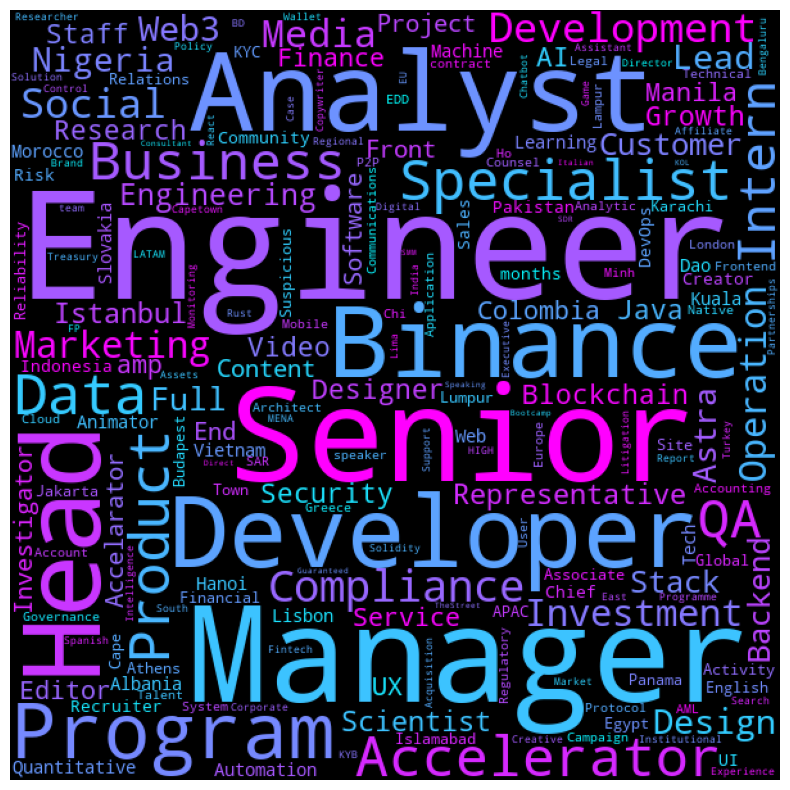

In [77]:
word_string=' '.join(df_crypto_jobs['Job Title'].astype("str").values)
STOPWORDS.update(['Job Vacancy','We are Hiring',"We're Hiring",
                 "Job","CO","https","t","hiring","jobs",
                 "apply","looking","career","link","click", "Crypto", "Remote"])
wordcloud = WordCloud(stopwords=STOPWORDS, 
                      collocations=False,
                      background_color ='Black',
                      min_font_size = 0.001,
                      # mask=background,
                     colormap="cool",
                     width=600, height=600).generate(word_string)
plt.subplots(figsize=(8,8))
plt.clf()
plt.imshow(wordcloud)
plt.axis('off')
plt.tight_layout()
plt.show()

2

In [79]:
import requests

url = "https://jobs.github.com/positions.json?description=api&location=new+york"

payload = {}
headers = {}

response = requests.request("GET", url, headers=headers, data=payload)

print(response.text)


ConnectionError: HTTPSConnectionPool(host='jobs.github.com', port=443): Max retries exceeded with url: /positions.json?description=api&location=new+york (Caused by NewConnectionError('<urllib3.connection.HTTPSConnection object at 0x11bf99b90>: Failed to establish a new connection: [Errno 61] Connection refused'))